# Grid Search using 50% Human Data, then Evaluate on other half

## Read Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

# Get data source
data_dir = '../../../../study data/Study 3/'

# Reportable data
simulated_results = data_dir + '0827_simulation_result_100m_50ep.csv'
# # Ablation study data: PMM
# ablation_PMM_simulated_results = data_dir + '0901_ablation_PMM_simulation_results_100ep.csv'
# # Ablation study data: Spatial Gaussian Distribution
# ablation_SGD_simulated_results = data_dir + '1120_ablation_spatial_gaussian_distribution_simulation_result_100ep.csv'
# Human data
human_duration_data = data_dir + 'human_data_reading_resumption_time_cost.csv'
human_error_rate_data = data_dir + 'human_data_reading_resumption_error_rate.csv'

# Read in as dataframe.
df_simulations = pd.read_csv(simulated_results)
# df_ablation_simulations = pd.read_csv(ablation_PMM_simulated_results)
human_duration_df = pd.read_csv(human_duration_data)
human_error_rate_df = pd.read_csv(human_error_rate_data)

params = {
    'init_delta_t':None,
    'init_sigma_position_memory':None,
    'weight_memory_decay':None,
    'spatial_dist_coeff':None,
}

layouts = ['L0', 'L50', 'L100']
metrics = ['steps', 'error']

# Get individual-level human data
# human_data_steps_list = [1.572, 1.246, 1.032]    # L0, L50, L100
# human_data_error_list = [9.311, 4.275, 2.016]    # L0, L50, L100
human_duration_data = [human_duration_df[col].tolist() for col in human_duration_df.columns if col != "Participant"]
human_error_data = [human_error_rate_df[col].tolist() for col in human_error_rate_df.columns if col != "Participant"]

In [2]:
human_duration_data

[[1.42, 1.13, 1.13, 4.23, 1.37, 1.81, 1.08, 1.45, 1.59, 1.79, 1.11, 0.75],
 [1.48, 1.94, 0.7, 3.19, 0.64, 1.23, 0.87, 1.11, 1.15, 1.13, 0.95, 0.56],
 [1.38, 1.11, 0.6, 3.36, 0.73, 0.83, 0.85, 0.96, 0.92, 0.78, 0.42, 0.44]]

In [3]:
human_error_data

[[15.46, 2.41, 6.36, 27.27, 3.92, 8.18, 2.0, 11.21, 0.73, 5.26, 10.92, 18.01],
 [2.99, 1.71, 2.96, 11.72, 0.0, 5.29, 1.45, 4.18, 1.98, 3.83, 10.31, 4.88],
 [3.29, 0.0, 0.84, 6.84, 0.91, 0.0, 0.6, 0.18, 0.47, 4.99, 2.12, 3.95]]

## Halve the human data into two parts - training and evaluation

In [3]:
prior_work_init_sigma_position_memory = 4.5
empirical_init_delta_time = 1

# Normalize a list
def normalize(lst):
    min_val = min(lst)
    max_val = max(lst)
    if min_val == max_val:  # Avoid division by zero
        return [0.5 for _ in lst]  # Return 0.5 (middle) if all values are same
    return [(x - min_val) / (max_val - min_val) for x in lst]

# Define the cost function
def compute_cost(sim_data, human_data):
    return sum(abs(sim - human) for sim, human in zip(sim_data, human_data))

def find_best_params(data, human_duration, human_error):
    # Filter the main dataframe to only consider rows where init_sigma_position_memory is 4.5
    data = data[
        (data['init_sigma_position_memory'] == prior_work_init_sigma_position_memory) 
        & (data['init_delta_t'] == empirical_init_delta_time)
    ]
    
    data_before_params_inf = data.copy()
    
    unique_params = data.drop(columns=['layout', 'steps', 'error']).drop_duplicates()
    min_cost = float('inf')
    best_params = None

    for index, row in unique_params.iterrows():
        filtered_df = data[
#             (data['init_delta_t'] == row['init_delta_t']) &
            # Comment this when trying to do pruned grid search
#             (data['init_sigma_position_memory'] == row['init_sigma_position_memory']) &
            (data['weight_memory_decay'] == row['weight_memory_decay']) &
            (data['spatial_dist_coeff'] == row['spatial_dist_coeff'])
        ]
        
        sim_steps = [filtered_df[filtered_df['layout'] == layout]['steps'].values[0] for layout in layouts]
        sim_error = [filtered_df[filtered_df['layout'] == layout]['error'].values[0] for layout in layouts]
        
        cost_steps = compute_cost(normalize(sim_steps), normalize(human_duration))
        cost_error = compute_cost(normalize(sim_error), normalize(human_error))
        
        total_cost = cost_steps + cost_error

        if total_cost < min_cost:
            min_cost = total_cost
            best_params = row
    
    # Given the best parameters and teh dataframe, return the simulated steps (durations) and errors for the three layouts
    sim_steps_best = []
    sim_errors_best = []
    
    # Extract the simulated steps and error for each layout based on best_params
    for layout in layouts:
        filtered_df = data[
#             (data['init_delta_t'] == best_params['init_delta_t']) &
            # Comment this when trying to do pruned grid search
#             (data['init_sigma_position_memory'] == best_params['init_sigma_position_memory']) &
            (data['weight_memory_decay'] == best_params['weight_memory_decay']) &
            (data['spatial_dist_coeff'] == best_params['spatial_dist_coeff']) &
            (data['layout'] == layout)
        ]
        
        sim_steps_best.append(filtered_df['steps'].values[0])
        sim_errors_best.append(filtered_df['error'].values[0])

    return best_params, min_cost, sim_steps_best, sim_errors_best

## Grid Search

In [5]:
%%time

num_iterations = 500
all_costs = []
all_best_params = []

# Lists to store sim-to-real mapping ratios for each iteration
sim_to_real_ratios_duration = []
sim_to_real_ratios_error = []

# Initialize dictionaries for storing results
simulated_durations = {'L0': [], 'L50': [], 'L100': []}
simulated_errors = {'L0': [], 'L50': [], 'L100': []}
human_train_durations = {'L0': [], 'L50': [], 'L100': []}
human_train_errors = {'L0': [], 'L50': [], 'L100': []}
human_test_durations = {'L0': [], 'L50': [], 'L100': []}
human_test_errors = {'L0': [], 'L50': [], 'L100': []}
human_train_durations_details = {'L0': [], 'L50': [], 'L100': []}  # Collect detailed data in each iterations, not aggregated
human_train_errors_details = {'L0': [], 'L50': [], 'L100': []}
human_test_durations_details = {'L0': [], 'L50': [], 'L100': []}
human_test_errors_details = {'L0': [], 'L50': [], 'L100': []}

for i in range(num_iterations):
    # Number of participants
    num_participants = len(human_duration_data[0])

    # Generate list of indices based on participants
    indices = list(range(num_participants))

    # Split indices to ensure consistency
    train_indices, test_indices = train_test_split(indices, test_size=0.5, random_state=i)  
    # using i as the seed for reproducibility

    # Use these indices to split the human data consistently across participants
    def split_data_based_on_indices(data, train_indices, test_indices):
        train_set = [data[i] for i in train_indices]
        test_set = [data[i] for i in test_indices]
        return train_set, test_set

    # Split human duration data
    train_duration = [split_data_based_on_indices(condition, train_indices, test_indices) for condition in human_duration_data]
    train_duration = list(zip(*train_duration))[0]  # Extracting the training data

    test_duration = [split_data_based_on_indices(condition, train_indices, test_indices) for condition in human_duration_data]
    test_duration = list(zip(*test_duration))[1]  # Extracting the test data

    # Split human error data
    train_error = [split_data_based_on_indices(condition, train_indices, test_indices) for condition in human_error_data]
    train_error = list(zip(*train_error))[0]  # Extracting the training data

    test_error = [split_data_based_on_indices(condition, train_indices, test_indices) for condition in human_error_data]
    test_error = list(zip(*test_error))[1]  # Extracting the test data

    # Compute mean for the training and test sets
    mean_train_duration = [np.mean(data) for data in train_duration]
    mean_train_error = [np.mean(data) for data in train_error]
    mean_test_duration = [np.mean(data) for data in test_duration]
    mean_test_error = [np.mean(data) for data in test_error]

    # Using the function to find the best parameters
    best_params, _, sim_durations, sim_errors = find_best_params(df_simulations, mean_train_duration, mean_train_error)
    all_best_params.append(best_params)
    
    # Get sim to real mapping ratios for duration and error metrics respectively
    # Compute sim-to-real ratio for the current iteration
    sim_to_real_ratio_duration = sum(mean_train_duration) / sum(sim_durations)
    sim_to_real_ratio_error = sum(mean_train_error) / sum(sim_errors)
    
    # Store the computed ratios
    sim_to_real_ratios_duration.append(sim_to_real_ratio_duration)
    sim_to_real_ratios_error.append(sim_to_real_ratio_error)
    
    for label, sd, se, ted, tee, trd, tre in zip(
        ['L0', 'L50', 'L100'], 
        sim_durations, 
        sim_errors, 
        test_duration, 
        test_error, 
        train_duration, 
        train_error,
    ):
        simulated_durations[label].append(sd)
        simulated_errors[label].append(se)
        human_train_durations[label].append(np.mean(trd))
        human_train_errors[label].append(np.mean(tre))
        human_test_durations[label].append(np.mean(ted))
        human_test_errors[label].append(np.mean(tee))
        human_train_durations_details[label].append(trd)
        human_train_errors_details[label].append(tre)
        human_test_durations_details[label].append(ted)
        human_test_errors_details[label].append(tee)

CPU times: total: 1min 44s
Wall time: 1min 49s


In [6]:
# Copy results for reproducibility
import copy

simulated_durations_copy = copy.deepcopy(simulated_durations)
simulated_errors_copy = copy.deepcopy(simulated_errors)
human_test_durations_copy = copy.deepcopy(human_test_durations)
human_test_errors_copy = copy.deepcopy(human_test_errors)
human_train_durations_copy = copy.deepcopy(human_train_durations)
human_train_errors_copy = copy.deepcopy(human_train_errors)
human_test_durations_details_copy = copy.deepcopy(human_test_durations_details)
human_test_errors_details_copy = copy.deepcopy(human_test_errors_details)
human_train_durations_details_copy = copy.deepcopy(human_train_durations_details)
human_train_errors_details_copy = copy.deepcopy(human_train_errors_details)

In [7]:
import csv
# Open a CSV file in write mode
best_params_file_name = data_dir + "1122_normal_1initdeltat_4dot5sigmapm_train_test_split_repeats_data_rep500.csv"

In [8]:
# Write
with open(best_params_file_name, "w", newline='') as csvfile:
    # Initialize the CSV writer
    writer = csv.writer(csvfile)

    # Write the headers
    headers = [
        "Layout", 
        "Simulated Durations", 
        "Simulated Errors", 
        "Simulated and Tuned Durations",
        "Simulated and Tuned Errors",
        "Human Train Durations", 
        "Human Train Errors", 
        "Human Test Durations",
        "Human Test Errors",
        "init_delta_t", 
        "init_sigma_position_memory", 
        "weight_memory_decay", 
        "spatial_dist_coeff",
        "Sim to Real Ratio Duration",
        "Sim to Real Ratio Error"
    ]
    writer.writerow(headers)
    
    # Write data for each layout
    for i, best_param in enumerate(all_best_params):
        for label in ['L0', 'L50', 'L100']:
            row = [
                label, 
                simulated_durations[label][i], 
                simulated_errors[label][i],
                simulated_durations[label][i] * sim_to_real_ratios_duration[i],
                simulated_errors[label][i] * sim_to_real_ratios_error[i],
                human_train_durations[label][i], 
                human_train_errors[label][i],
                human_test_durations[label][i],
                human_test_errors[label][i],
                best_param[0],  # init_delta_t
                best_param[1],  # init_sigma_position_memory
                best_param[2],  # weight_memory_decay
                best_param[3],  # spatial_dist_coeff
                sim_to_real_ratios_duration[i],
                sim_to_real_ratios_error[i]
            ]
            writer.writerow(row)

## Data evaluation

In [9]:
import pandas as pd
import copy

# best_params_file_name = "study3_readingresumption/1118_normal_oneinitdeltat_4dot5sigmapm_train_test_split_repeats_data_rep500.csv"

# Read in the CSV file
data = pd.read_csv(best_params_file_name)

# Create dictionaries to store data by layout and type
simulated_durations = {'L0': [], 'L50': [], 'L100': []}
simulated_errors = {'L0': [], 'L50': [], 'L100': []}
human_train_durations = {'L0': [], 'L50': [], 'L100': []}
human_train_errors = {'L0': [], 'L50': [], 'L100': []}
human_test_durations = {'L0': [], 'L50': [], 'L100': []}
human_test_errors = {'L0': [], 'L50': [], 'L100': []}
sim_to_real_ratios_duration = {'L0': [], 'L50': [], 'L100': []}
sim_to_real_ratios_error = {'L0': [], 'L50': [], 'L100': []}
# sim_to_real_ratios_duration = []
# sim_to_real_ratios_error = []

# Iterate through each row in the dataset
for index, row in data.iterrows():
    layout = row['Layout']
    simulated_durations[layout].append(row['Simulated Durations'])
    simulated_errors[layout].append(row['Simulated Errors'])
    human_train_durations[layout].append(row['Human Train Durations'])
    human_train_errors[layout].append(row['Human Train Errors'])
    human_test_durations[layout].append(row['Human Test Durations'])
    human_test_errors[layout].append(row['Human Test Errors'])
    sim_to_real_ratios_duration[layout].append(row['Sim to Real Ratio Duration'])
    sim_to_real_ratios_error[layout].append(row['Sim to Real Ratio Error'])

num_iterations = int(data.shape[0] / 3)

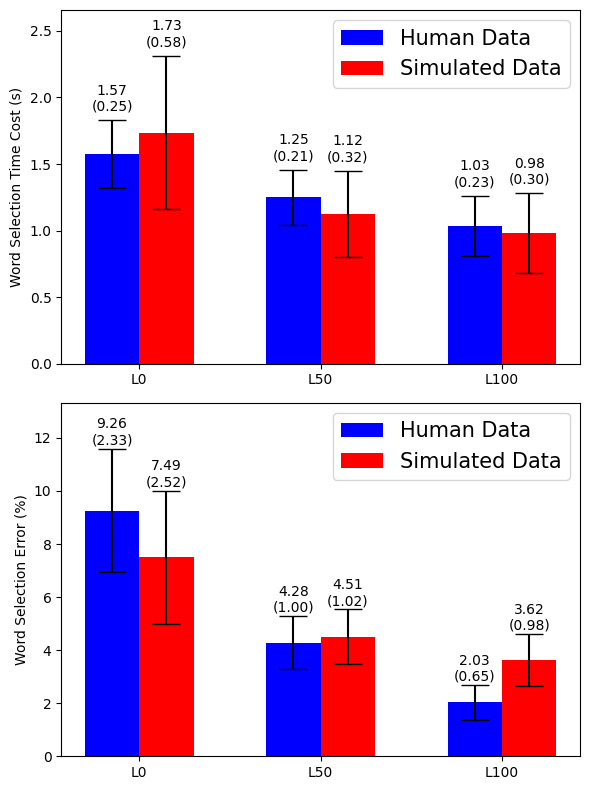

In [10]:
import matplotlib.pyplot as plt
import numpy as np

simulated_durations_copy = copy.deepcopy(simulated_durations)
simulated_errors_copy = copy.deepcopy(simulated_errors)
human_test_durations_copy = copy.deepcopy(human_test_durations)
human_test_errors_copy = copy.deepcopy(human_test_errors)
human_train_durations_copy = copy.deepcopy(human_train_durations)
human_train_errors_copy = copy.deepcopy(human_train_errors)

labels = ['L0', 'L50', 'L100']

# Calculate SEM
def std(data):
    return np.std(data) #/ np.sqrt(len(data))

# Function to adjust y-limit
def adjust_ylim(ax, means, sems):
    y_max = max([mean + sem for mean, sem in zip(means, sems)])
    ax.set_ylim(0, y_max * 1.15)  # Adding a bit of margin to the top

# Using the average results for the test set
mean_human_test_duration = [np.mean(human_test_durations_copy[label]) for label in labels]
std_human_test_duration = [std(human_test_durations_copy[label]) for label in labels]
mean_human_test_error = [np.mean(human_test_errors_copy[label]) for label in labels]
std_human_test_error = [std(human_test_errors_copy[label]) for label in labels]

# Adjust the simulated data with ratios
for iteration in range(num_iterations):
    for label in labels:
        simulated_durations_copy[label][iteration] *= sim_to_real_ratios_duration[layout][iteration]
        simulated_errors_copy[label][iteration] *= sim_to_real_ratios_error[layout][iteration]

# Now recompute the mean and sem for these adjusted simulated results
mean_simulated_duration = [np.mean(simulated_durations_copy[label]) for label in labels]
std_simulated_duration = [std(simulated_durations_copy[label]) for label in labels]
mean_simulated_error = [np.mean(simulated_errors_copy[label]) for label in labels]
std_simulated_error = [std(simulated_errors_copy[label]) for label in labels]

# Calculate 95% confidence interval ######################################################################
# def confidence_interval(data):
#     n = len(data)
#     mean = np.mean(data)
#     std_err = np.std(data) / np.sqrt(n)
    
#     # Assuming t-distribution (for n > 30 you can use 1.96 which is z-distribution for 95% CI)
#     confidence = 1.96
#     margin_of_error = std_err * confidence
#     return margin_of_error

# # Update the error computation for plotting
# std_human_test_duration = [confidence_interval(human_test_durations_copy[label]) for label in labels]
# std_simulated_duration = [confidence_interval(simulated_durations_copy[label]) for label in labels]
# std_human_test_error = [confidence_interval(human_test_errors_copy[label]) for label in labels]
# std_simulated_error = [confidence_interval(simulated_errors_copy[label]) for label in labels]

###########################################################################################################

# Update the plotting logic
x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(2, 1, figsize=(6, 8))

# Plot for Duration
rects1 = ax[0].bar(x - width/2, mean_human_test_duration, width, label='Human Data', color='blue', yerr=std_human_test_duration, capsize=10)
rects2 = ax[0].bar(x + width/2, mean_simulated_duration, width, label='Simulated Data', color='red', yerr=std_simulated_duration, capsize=10)

# Plot for Error
rects3 = ax[1].bar(x - width/2, mean_human_test_error, width, label='Human Data', color='blue', yerr=std_human_test_error, capsize=10)
rects4 = ax[1].bar(x + width/2, mean_simulated_error, width, label='Simulated Data', color='red', yerr=std_simulated_error, capsize=10)

# Annotating bars
for i, (rect1, rect2) in enumerate(zip(rects1, rects2)):
    height1 = rect1.get_height()
    height2 = rect2.get_height()
    std1 = std_human_test_duration[i]
    std2 = std_simulated_duration[i]
    ax[0].annotate(f"{height1:.2f}\n({std1:.2f})", 
                   (rect1.get_x() + rect1.get_width() / 2., height1 + std1 + 0.05),
                   ha='center', va='bottom')
    ax[0].annotate(f"{height2:.2f}\n({std2:.2f})", 
                   (rect2.get_x() + rect2.get_width() / 2., height2 + std2 + 0.05),
                   ha='center', va='bottom')

for i, (rect3, rect4) in enumerate(zip(rects3, rects4)):
    height3 = rect3.get_height()
    height4 = rect4.get_height()
    std3 = std_human_test_error[i]
    std4 = std_simulated_error[i]
    ax[1].annotate(f"{height3:.2f}\n({std3:.2f})", 
                   (rect3.get_x() + rect3.get_width() / 2., height3 + std3 + 0.05),
                   ha='center', va='bottom')
    ax[1].annotate(f"{height4:.2f}\n({std4:.2f})", 
                   (rect4.get_x() + rect4.get_width() / 2., height4 + std4 + 0.05),
                   ha='center', va='bottom')

# Labels, title, and custom x-axis tick labels
ax[0].set_ylabel('Word Selection Time Cost (s)')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend(fontsize=15)
adjust_ylim(ax[0], mean_human_test_duration + mean_simulated_duration, std_human_test_duration + std_simulated_duration)

ax[1].set_ylabel('Word Selection Error (%)')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend(fontsize=15)
adjust_ylim(ax[1], mean_human_test_error + mean_simulated_error, std_human_test_error + std_simulated_error)

fig.tight_layout()
plt.show()

### Save plots

In [11]:
fig_duration, ax_duration = plt.subplots(figsize=(6, 4))
rects1 = ax_duration.bar(x - width/2, mean_human_test_duration, width, label='Human Data', color='blue', yerr=std_human_test_duration, capsize=10)
rects2 = ax_duration.bar(x + width/2, mean_simulated_duration, width, label='Simulated Data', color='red', yerr=std_simulated_duration, capsize=10)

# Annotations for Duration plot
for i, (rect1, rect2) in enumerate(zip(rects1, rects2)):
    height1 = rect1.get_height()
    height2 = rect2.get_height()
    std1 = std_human_test_duration[i]
    std2 = std_simulated_duration[i]
    ax_duration.annotate(f"{height1:.2f}\n({std1:.2f})", 
                   (rect1.get_x() + rect1.get_width() / 2., height1 + std1 + 0.05),
                   ha='center', va='bottom')
    ax_duration.annotate(f"{height2:.2f}\n({std2:.2f})", 
                   (rect2.get_x() + rect2.get_width() / 2., height2 + std2 + 0.05),
                   ha='center', va='bottom')

# Labels for Duration plot
ax_duration.set_ylabel('Reading Resumption Time (s)', fontsize=14)
ax_duration.set_xticks(x)
ax_duration.set_xticklabels(labels, fontsize=12, fontweight='bold')
ax_duration.tick_params(axis='y', labelsize=14)  # Adjust the fontsize as desired for y-axis

ax_duration.legend(fontsize=15)
adjust_ylim(ax_duration, mean_human_test_duration + mean_simulated_duration, std_human_test_duration + std_simulated_duration)

# Also, if you want the axis tick numbers to be larger:
ax_duration.tick_params(axis='both', labelsize=12)

fig_duration.tight_layout()
fig_duration.savefig(data_dir + 'taskresumptiontimecost.png', dpi=300)
plt.close(fig_duration)

In [12]:
fig_error, ax_error = plt.subplots(figsize=(6, 4))
rects3 = ax_error.bar(x - width/2, mean_human_test_error, width, label='Human Data', color='blue', yerr=std_human_test_error, capsize=10)
rects4 = ax_error.bar(x + width/2, mean_simulated_error, width, label='Simulated Data', color='red', yerr=std_simulated_error, capsize=10)

# Annotations for Error plot
for i, (rect3, rect4) in enumerate(zip(rects3, rects4)):
    height3 = rect3.get_height()
    height4 = rect4.get_height()
    std3 = std_human_test_error[i]
    std4 = std_simulated_error[i]
    ax_error.annotate(f"{height3:.2f}\n({std3:.2f})", 
                   (rect3.get_x() + rect3.get_width() / 2., height3 + std3 + 0.05),
                   ha='center', va='bottom')
    ax_error.annotate(f"{height4:.2f}\n({std4:.2f})", 
                   (rect4.get_x() + rect4.get_width() / 2., height4 + std4 + 0.05),
                   ha='center', va='bottom')

# Labels for Error plot
ax_error.set_ylabel('Reading Resumption Error Rate (%)', fontsize=14)
ax_error.tick_params(axis='y', labelsize=14)  # Adjust the fontsize as desired for y-axis
ax_error.set_xticks(x)
ax_error.set_xticklabels(labels, fontsize=12, fontweight='bold')
ax_error.legend(fontsize=15)
adjust_ylim(ax_error, mean_human_test_error + mean_simulated_error, std_human_test_error + std_simulated_error)

# Also, if you want the axis tick numbers to be larger:
ax_duration.tick_params(axis='both', labelsize=12)

fig_error.tight_layout()
fig_error.savefig(data_dir + 'taskresumptionerrorrate.png', dpi=300)
plt.close(fig_error)

### RSME

In [13]:
import pandas as pd

# Read in the CSV file
data = pd.read_csv(best_params_file_name)

# Create dictionaries to store data by layout and type
simulated_durations = {'L0': [], 'L50': [], 'L100': []}
simulated_errors = {'L0': [], 'L50': [], 'L100': []}
simulated_tuned_durations = {'L0': [], 'L50': [], 'L100': []}
simulated_tuned_errors = {'L0': [], 'L50': [], 'L100': []}
human_train_durations = {'L0': [], 'L50': [], 'L100': []}
human_train_errors = {'L0': [], 'L50': [], 'L100': []}
human_test_durations = {'L0': [], 'L50': [], 'L100': []}
human_test_errors = {'L0': [], 'L50': [], 'L100': []}
sim_to_real_ratios_duration = {'L0': [], 'L50': [], 'L100': []}
sim_to_real_ratios_error = {'L0': [], 'L50': [], 'L100': []}
# sim_to_real_ratios_duration = []
# sim_to_real_ratios_error = []

# Iterate through each row in the dataset
for index, row in data.iterrows():
    layout = row['Layout']
    simulated_durations[layout].append(row['Simulated Durations'])
    simulated_errors[layout].append(row['Simulated Errors'])
    simulated_tuned_durations[layout].append(row['Simulated and Tuned Durations'])
    simulated_tuned_errors[layout].append(row['Simulated and Tuned Errors'])
    human_train_durations[layout].append(row['Human Train Durations'])
    human_train_errors[layout].append(row['Human Train Errors'])
    human_test_durations[layout].append(row['Human Test Durations'])
    human_test_errors[layout].append(row['Human Test Errors'])
    sim_to_real_ratios_duration[layout].append(row['Sim to Real Ratio Duration'])
    sim_to_real_ratios_error[layout].append(row['Sim to Real Ratio Error'])

num_iterations = int(data.shape[0] / 3)

In [14]:
# Get rsme
simulated_durations_copy = copy.deepcopy(simulated_durations)
simulated_errors_copy = copy.deepcopy(simulated_errors)
human_test_durations_copy = copy.deepcopy(human_test_durations)
human_test_errors_copy = copy.deepcopy(human_test_errors)
human_train_durations_copy = copy.deepcopy(human_train_durations)
human_train_errors_copy = copy.deepcopy(human_train_errors)
human_test_durations_details_copy = copy.deepcopy(human_test_durations_details)
human_test_errors_details_copy = copy.deepcopy(human_test_errors_details)
human_train_durations_details_copy = copy.deepcopy(human_train_durations_details)
human_train_errors_details_copy = copy.deepcopy(human_train_errors_details)


# Adjust the simulated data with ratios
for iteration in range(num_iterations):
    for label in labels:
        simulated_durations_copy[label][iteration] *= sim_to_real_ratios_duration[label][iteration]
        simulated_errors_copy[label][iteration] *= sim_to_real_ratios_error[label][iteration]

# RMSE computation function
def compute_rmse(true_vals, predicted_vals):
    return np.sqrt(np.mean((np.array(true_vals) - np.array(predicted_vals)) ** 2))

# Compute RMSE for durations and errors for each layout
rmse_durations_layouts = {}
rmse_errors_layouts = {}

for label in labels:
    rmse_durations_layouts[label] = compute_rmse(human_test_durations_copy[label], simulated_durations_copy[label])
    rmse_errors_layouts[label] = compute_rmse(human_test_errors_copy[label], simulated_errors_copy[label])

# Average RMSE across all layouts
avg_rmse_durations = np.mean(list(rmse_durations_layouts.values()))
avg_rmse_errors = np.mean(list(rmse_errors_layouts.values()))

# Display results
print(f"Average RMSE between simulated durations and human test durations: {avg_rmse_durations:.4f}")
print(f"Average RMSE between simulated errors and human test errors: {avg_rmse_errors:.4f}")
for label in labels:
    print(f"RMSE for {label} - Durations: {rmse_durations_layouts[label]:.4f}, Errors: {rmse_errors_layouts[label]:.4f}")


Average RMSE between simulated durations and human test durations: 0.5841
Average RMSE between simulated errors and human test errors: 3.0354
RMSE for L0 - Durations: 0.7738, Errors: 5.0159
RMSE for L50 - Durations: 0.5022, Errors: 1.9790
RMSE for L100 - Durations: 0.4762, Errors: 2.1114


# Ablation Study

### The Re-trained Model

In [4]:
import pandas as pd
import numpy as np

# With the re-trained model:
# Get data source (read data)
data_dir = '../../../../study data/Study 3/'
# Reportable data - very original simulated data, before the parameter inference
simulated_results = data_dir + '0827_simulation_result_100m_50ep.csv'
# Ablation study data: PMM
ablation_PMM_simulated_results = data_dir + '0901_ablation_PMM_simulation_results_100ep.csv'
# Ablation study data: Spatial Gaussian Distribution (SGD)
ablation_SGD_simulated_results = data_dir + '1120_ablation_spatial_gaussian_distribution_simulation_result_100ep.csv'
# Human data
human_duration_data = data_dir + 'human_data_reading_resumption_time_cost.csv'
human_error_rate_data = data_dir + 'human_data_reading_resumption_error_rate.csv'
# The simulated data but after the parameter inference
# Parameter inferenced simulation + human data with train-test splits
# best_params_file_name = data_dir + "1121_normal_oneinitdeltat_4dot5sigmapm_train_test_split_repeats_data_rep500.csv"
best_params_file_name = data_dir + '1122_normal_1initdeltat_4dot5sigmapm_train_test_split_repeats_data_rep500.csv'
# "0906_normal_oneinitdeltat_4dot5sigmapm_train_test_split_repeats_data_rep500.csv"
simulated_data_before_params_inf = data_dir + '1122_simulated_data_before_params_inf.csv'

df_ablation_PMM_simulations = pd.read_csv(ablation_PMM_simulated_results)
df_ablation_SGD_simulations = pd.read_csv(ablation_SGD_simulated_results)

# Define a function to get ablation data based on parameters
def get_ablation_data(df, params):
    condition = (df['init_delta_t'] == params[0]) & \
                 (df['init_sigma_position_memory'] == params[1]) & \
                 (df['weight_memory_decay'] == params[2]) & \
                 (df['spatial_dist_coeff'] == params[3]) & \
                 (df['layout'] == params[4])  # I forgot to add this condition in the first edition's ablation study
    filtered_df = df[condition]
    # Assuming the ablation dataset has columns for 'duration' and 'error'
    durations = filtered_df['steps'].tolist()
    errors = filtered_df['error'].tolist()
    return durations, errors

# Create a new file and store data in there.
extended_file_name = data_dir + "1122_extended_normal_1initdeltat_4dot5sigmapm_train_test_split_repeats_data_rep500.csv"

# Read the existing data from the best_params_file_name
df_best_params = pd.read_csv(best_params_file_name)
# Modify the dataframe to add columns for ablation data
# For the PMM ablation study
df_best_params["Ablation PMM Durations"] = np.nan
df_best_params["Ablation PMM Errors"] = np.nan
# For the SGD ablation study
df_best_params["Ablation SGD Durations"] = np.nan
df_best_params["Ablation SGD Errors"] = np.nan

# Update the dataframe rows with ablation data based on the best parameters
for i, row in df_best_params.iterrows():
    best_param = (
        row["init_delta_t"],
        row["init_sigma_position_memory"],
        row["weight_memory_decay"],
        row["spatial_dist_coeff"],
        row["Layout"], # I forgot to add this in the first edition paper when doing the ablation study. This makes the ablated results cannot tell the difference across the three text laouts. 
    )
    ablation_PMM_durations, ablation_PMM_errors = get_ablation_data(df_ablation_PMM_simulations, best_param)
    ablation_SGD_durations, ablation_SGD_errors = get_ablation_data(df_ablation_SGD_simulations, best_param)
    
    # Here, I'm assuming that the ablation data results in one value for each label ('L0', 'L50', 'L100')
    # and so we're directly updating the dataframe's ablation columns. Adjust as necessary.
    df_best_params.at[i, "Ablation PMM Durations"] = ablation_PMM_durations[0]  # or whichever index corresponds to the label
    df_best_params.at[i, "Ablation PMM Errors"] = ablation_PMM_errors[0]
    df_best_params.at[i, "Ablation SGD Durations"] = ablation_SGD_durations[0]  # or whichever index corresponds to the label
    df_best_params.at[i, "Ablation SGD Errors"] = ablation_SGD_errors[0]

# Write the modified dataframe to the extended_file_name
df_best_params.to_csv(extended_file_name, index=False)

In [5]:
# Get mean, std, and corresponding mapping ratio from the simualted data without fine-tuning.
df_before_param_infer = pd.read_csv(simulated_results)
df_after_param_infer = pd.read_csv(best_params_file_name)

# Filtering the DataFrame with fixed parameters
filtered_data = df_before_param_infer[
    (df_before_param_infer['init_sigma_position_memory'] == prior_work_init_sigma_position_memory) 
    & (df_before_param_infer['init_delta_t'] == empirical_init_delta_time)
]

filtered_data.to_csv(simulated_data_before_params_inf, index=False)

# Get the average steps and error for each layout
avg_metrics = filtered_data.groupby('layout')[['steps', 'error']].mean().reset_index()
# Calculate standard deviation of steps and error for each layout
std_metrics = filtered_data.groupby('layout')[['steps', 'error']].std().reset_index()

# Get the average sim to real mapping for steps and error
avg_ratios = df_after_param_infer[['Sim to Real Ratio Duration', 'Sim to Real Ratio Error']].mean().reset_index()
ratio_duration = avg_ratios[0][0]
ratio_error = avg_ratios[0][1]

In [6]:
avg_metrics

,layout,steps,error
0,L0,50.748889,0.769697
1,L100,27.847071,0.595960
2,L50,33.340606,0.535657


In [7]:
avg_metrics[avg_metrics['layout'] == 'L0']['steps']

0    50.748889
Name: steps, dtype: float64

In [8]:
avg_metrics['steps']

0    50.748889
1    27.847071
2    33.340606
Name: steps, dtype: float64

In [9]:
std_metrics

,layout,steps,error
0,L0,17.847015,0.329825
1,L100,20.787344,0.344525
2,L50,19.142904,0.269103


In [10]:
ratio_duration, ratio_error

(0.034739049009101054, 8.260270983637453)

In [11]:
# Read the data
df = pd.read_csv(extended_file_name)
df

,Layout,Simulated Durations,Simulated Errors,Simulated and Tuned Durations,Simulated and Tuned Errors,Human Train Durations,Human Train Errors,Human Test Durations,Human Test Errors,init_delta_t,init_sigma_position_memory,weight_memory_decay,spatial_dist_coeff,Sim to Real Ratio Duration,Sim to Real Ratio Error,Ablation PMM Durations,Ablation PMM Errors,Ablation SGD Durations,Ablation SGD Errors
0,L0,64.24,1.06,1.879461,7.596667,1.971667,11.631667,1.171667,6.990000,1.0,4.5,0.55,5.0,0.029257,7.166667,6.0,3.40,56.68,0.78
1,L50,59.26,0.83,1.733761,5.948333,1.680000,4.953333,0.811667,3.596667,1.0,4.5,0.55,5.0,0.029257,7.166667,6.0,3.09,55.78,0.60
2,L100,49.28,0.78,1.441778,5.590000,1.403333,2.550000,0.660000,1.481667,1.0,4.5,0.55,5.0,0.029257,7.166667,6.0,2.02,56.54,1.22
3,L0,63.46,1.29,1.426237,8.947018,1.468333,9.808333,1.675000,8.813333,1.0,4.5,0.90,4.5,0.022475,6.935673,6.0,4.19,51.04,1.05
4,L50,47.08,0.57,1.058103,3.953333,1.110000,3.858333,1.381667,4.691667,1.0,4.5,0.90,4.5,0.022475,6.935673,6.0,2.70,58.92,0.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,L50,47.08,0.57,1.108514,3.036250,1.123333,3.045000,1.368333,5.505000,1.0,4.5,0.90,4.5,0.023545,5.326754,6.0,2.70,58.92,0.94
1496,L100,43.56,0.42,1.025634,2.237237,0.933333,1.640000,1.130000,2.391667,1.0,4.5,0.90,4.5,0.023545,5.326754,6.0,1.70,70.22,0.81
1497,L0,64.24,1.06,1.281479,5.112085,1.420000,7.633333,1.723333,10.988333,1.0,4.5,0.55,5.0,0.019948,4.822722,6.0,3.40,56.68,0.78
1498,L50,59.26,0.83,1.182136,4.002859,1.186667,3.645000,1.305000,4.905000,1.0,4.5,0.55,5.0,0.019948,4.822722,6.0,3.09,55.78,0.60


the new mean duration is:[1.7629681382685352, 1.1582209479325254, 0.9673807540528317], its std is: [0.6199883290051562, 0.6650062631539564, 0.7221325665399873], 
 the errors is:[6.357905544981555, 4.42466838648782, 4.9227877579253505], std is:[2.7244447598452615, 2.222867259364433, 2.8458736805141336]


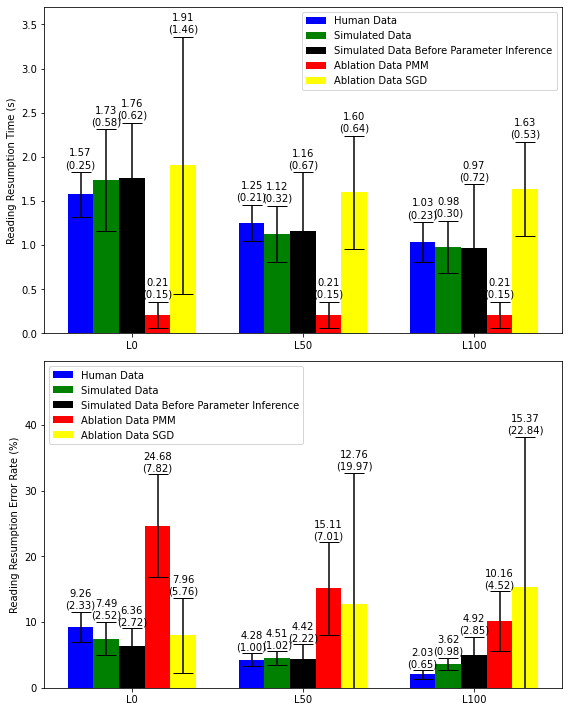

In [12]:
import matplotlib.pyplot as plt

alpha = 0.05

# Reorder the data based on the desired order of the Layouts
df = df.set_index('Layout').loc[['L0', 'L50', 'L100']].reset_index()

labels = ['L0', 'L50', 'L100']
Lables_index = {
    'L0':0,
    'L50':1,
    'L100':2,
}
    
## Using list comprehension to create nested lists based on Layout
human_test_durations = [df[df['Layout'] == layout]['Human Test Durations'].tolist() for layout in labels]
human_test_errors = [df[df['Layout'] == layout]['Human Test Errors'].tolist() for layout in labels]
simulated_durations = [df[df['Layout'] == layout]['Simulated Durations'].tolist() for layout in labels]
simulated_errors = [df[df['Layout'] == layout]['Simulated Errors'].tolist() for layout in labels]
ablation_PMM_durations = [df[df['Layout'] == layout]['Ablation PMM Durations'].tolist() for layout in labels]
ablation_PMM_errors = [df[df['Layout'] == layout]['Ablation PMM Errors'].tolist() for layout in labels]
ablation_SGD_durations = [df[df['Layout'] == layout]['Ablation SGD Durations'].tolist() for layout in labels]
ablation_SGD_errors = [df[df['Layout'] == layout]['Ablation SGD Errors'].tolist() for layout in labels]
sim_to_real_ratios_duration = [df[df['Layout'] == layout]['Sim to Real Ratio Duration'].tolist() for layout in labels]
sim_to_real_ratios_error = [df[df['Layout'] == layout]['Sim to Real Ratio Error'].tolist() for layout in labels]

# Compute the mean and std for human test data
mean_human_test_duration = [np.mean(human_test_durations[Lables_index[label]]) for label in labels]
std_human_test_duration = [np.std(human_test_durations[Lables_index[label]]) for label in labels]
mean_human_test_error = [np.mean(human_test_errors[Lables_index[label]]) for label in labels]
std_human_test_error = [np.std(human_test_errors[Lables_index[label]]) for label in labels]

# Adjust the simulated and ablation data with ratios
for i, label in enumerate(labels):
    simulated_durations[i] = [sd * ratio for sd, ratio in zip(simulated_durations[i], sim_to_real_ratios_duration[i])]
    simulated_errors[i] = [se * ratio for se, ratio in zip(simulated_errors[i], sim_to_real_ratios_error[i])]
    ablation_PMM_durations[i] = [ad * ratio for ad, ratio in zip(ablation_PMM_durations[i], sim_to_real_ratios_duration[i])]
    ablation_PMM_errors[i] = [ae * ratio for ae, ratio in zip(ablation_PMM_errors[i], sim_to_real_ratios_error[i])]
    ablation_SGD_durations[i] = [ad * ratio for ad, ratio in zip(ablation_SGD_durations[i], sim_to_real_ratios_duration[i])]
    ablation_SGD_errors[i] = [ae * ratio for ae, ratio in zip(ablation_SGD_errors[i], sim_to_real_ratios_error[i])]

# Compute the mean and std for original simulated data
mean_simulated_duration = [np.mean(simulated_durations[Lables_index[label]]) for label in labels]
std_simulated_duration = [np.std(simulated_durations[Lables_index[label]]) for label in labels]
mean_simulated_error = [np.mean(simulated_errors[Lables_index[label]]) for label in labels]
std_simulated_error = [np.std(simulated_errors[Lables_index[label]]) for label in labels]

# Get the mean and std for simulated data without the parameter inference.
mean_simulated_beforeParamTune_duration = [avg_metrics[avg_metrics['layout'] == label]['steps'].iloc[0]*ratio_duration for label in labels]
std_simulated_beforeParamTune_duration = [std_metrics[avg_metrics['layout'] == label]['steps'].iloc[0]*ratio_duration for label in labels]
mean_simulated_beforeParamTune_error = [avg_metrics[avg_metrics['layout'] == label]['error'].iloc[0]*ratio_error for label in labels]
std_simulated_beforeParamTune_error = [std_metrics[avg_metrics['layout'] == label]['error'].iloc[0]*ratio_error for label in labels]
print(f'the new mean duration is:{mean_simulated_beforeParamTune_duration}, its std is: {std_simulated_beforeParamTune_duration}, \n the errors is:{mean_simulated_beforeParamTune_error}, std is:{std_simulated_beforeParamTune_error}')

# Compute the mean and standard deviation for ablation data - PMM
mean_ablation_PMM_duration = [np.mean(ablation_PMM_durations[Lables_index[label]]) for label in labels]
std_ablation_PMM_duration = [np.std(ablation_PMM_durations[Lables_index[label]]) for label in labels]
mean_ablation_PMM_error = [np.mean(ablation_PMM_errors[Lables_index[label]]) for label in labels]
std_ablation_PMM_error = [np.std(ablation_PMM_errors[Lables_index[label]]) for label in labels]
# Compute the mean and standard deviation for ablation data - SGD
mean_ablation_SGD_duration = [np.mean(ablation_SGD_durations[Lables_index[label]]) for label in labels]
std_ablation_SGD_duration = [np.std(ablation_SGD_durations[Lables_index[label]]) for label in labels]
mean_ablation_SGD_error = [np.mean(ablation_SGD_errors[Lables_index[label]]) for label in labels]
std_ablation_SGD_error = [np.std(ablation_SGD_errors[Lables_index[label]]) for label in labels]

########################################################### Plot (visualisation) #####################################################################
# Update the plotting logic with added space for the ablation bars
x = np.arange(len(labels))
width = 0.15

fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# Plot for Duration
ax[0].bar(x - 2*width, mean_human_test_duration, width, label='Human Data', color='blue', yerr=std_human_test_duration, capsize=10)
ax[0].bar(x - 1*width, mean_simulated_duration, width, label='Simulated Data', color='green', yerr=std_simulated_duration, capsize=10)
ax[0].bar(x + 0*width, mean_simulated_beforeParamTune_duration, width, label='Simulated Data Before Parameter Inference', color='black', yerr=std_simulated_beforeParamTune_duration, capsize=10)
ax[0].bar(x + 1*width, mean_ablation_PMM_duration, width, label='Ablation Data PMM', color='red', yerr=std_ablation_PMM_duration, capsize=10)
ax[0].bar(x + 2*width, mean_ablation_SGD_duration, width, label='Ablation Data SGD', color='yellow', yerr=std_ablation_SGD_duration, capsize=10)

# Plot for Error
ax[1].bar(x - 2*width, mean_human_test_error, width, label='Human Data', color='blue', yerr=std_human_test_error, capsize=10)
ax[1].bar(x - 1*width, mean_simulated_error, width, label='Simulated Data', color='green', yerr=std_simulated_error, capsize=10)
ax[1].bar(x - 0*width, mean_simulated_beforeParamTune_error, width, label='Simulated Data Before Parameter Inference', color='black', yerr=std_simulated_beforeParamTune_error, capsize=10)
ax[1].bar(x + 1*width, mean_ablation_PMM_error, width, label='Ablation Data PMM', color='red', yerr=std_ablation_PMM_error, capsize=10)
ax[1].bar(x + 2*width, mean_ablation_SGD_error, width, label='Ablation Data SGD', color='yellow', yerr=std_ablation_SGD_error, capsize=10)

leviation_offset_duration = 0.05
leviation_offset_error_rate = 0.5

# Annotations for Duration bars
for idx in x:
    h = mean_human_test_duration[idx]
    s = mean_simulated_duration[idx]
    s_bpi = mean_simulated_beforeParamTune_duration[idx]
    a_pmm = mean_ablation_PMM_duration[idx]
    a_sgd = mean_ablation_SGD_duration[idx]

    std_h = std_human_test_duration[idx]
    std_s = std_simulated_duration[idx]
    std_bpi = std_simulated_beforeParamTune_duration[idx]
    std_a_pmm = std_ablation_PMM_duration[idx]
    std_a_sgd = std_ablation_SGD_duration[idx]

    ax[0].annotate(f"{h:.2f}\n({std_h:.2f})", xy=(idx - 2*width, h + std_h + leviation_offset_duration), ha='center')
    ax[0].annotate(f"{s:.2f}\n({std_s:.2f})", xy=(idx - 1*width, s + std_s + leviation_offset_duration), ha='center')
    ax[0].annotate(f"{s_bpi:.2f}\n({std_bpi:.2f})", xy=(idx - 0*width, s_bpi + std_bpi + leviation_offset_duration), ha='center')
    ax[0].annotate(f"{a_pmm:.2f}\n({std_a_pmm:.2f})", xy=(idx + 1*width, a_pmm + std_a_pmm + leviation_offset_duration), ha='center')
    ax[0].annotate(f"{a_sgd:.2f}\n({std_a_sgd:.2f})", xy=(idx + 2*width, a_sgd + std_a_sgd + leviation_offset_duration), ha='center')

# Annotations for Error bars
for idx in x:
    h = mean_human_test_error[idx]
    s = mean_simulated_error[idx]
    s_bpi = mean_simulated_beforeParamTune_error[idx]
    a_pmm = mean_ablation_PMM_error[idx]
    a_sgd = mean_ablation_SGD_error[idx]

    std_h = std_human_test_error[idx]
    std_s = std_simulated_error[idx]
    std_bpi = std_simulated_beforeParamTune_error[idx]
    std_a_pmm = std_ablation_PMM_error[idx]
    std_a_sgd = std_ablation_SGD_error[idx]
    
    ax[1].annotate(f"{h:.2f}\n({std_h:.2f})", xy=(idx - 2*width, h + std_h + leviation_offset_error_rate), ha='center')
    ax[1].annotate(f"{s:.2f}\n({std_s:.2f})", xy=(idx - 1*width, s + std_s + leviation_offset_error_rate), ha='center')
    ax[1].annotate(f"{s_bpi:.2f}\n({std_bpi:.2f})", xy=(idx - 0*width, s_bpi + std_bpi + leviation_offset_error_rate), ha='center')
    ax[1].annotate(f"{a_pmm:.2f}\n({std_a_pmm:.2f})", xy=(idx + 1*width, a_pmm + std_a_pmm + leviation_offset_error_rate), ha='center')
    ax[1].annotate(f"{a_sgd:.2f}\n({std_a_sgd:.2f})", xy=(idx + 2*width, a_sgd + std_a_sgd + leviation_offset_error_rate), ha='center')

    
# Calculate the maximum value with error for Duration and set y-limit accordingly
max_val_duration = max(
    [m + s for m, s in zip(mean_simulated_duration, std_simulated_duration)] + 
    [m + s for m, s in zip(mean_simulated_beforeParamTune_duration, std_simulated_beforeParamTune_duration)] + 
    [m + s for m, s in zip(mean_ablation_PMM_duration, std_ablation_PMM_duration)] + 
    [m + s for m, s in zip(mean_ablation_SGD_duration, std_ablation_SGD_duration)]
)
ax[0].set_ylim(0, max_val_duration * 1.1)  # Using 1.1 gives 10% padding at the top

# Calculate the maximum value with error for Error and set y-limit accordingly
max_val_error = max(
    [m + s for m, s in zip(mean_simulated_error, std_simulated_error)] + 
    [m + s for m, s in zip(mean_simulated_beforeParamTune_error, std_simulated_beforeParamTune_error)] + 
    [m + s for m, s in zip(mean_ablation_PMM_error, std_ablation_PMM_error)] + 
    [m + s for m, s in zip(mean_ablation_SGD_error, std_ablation_SGD_error)]
)
ax[1].set_ylim(0, max_val_error * 1.3)  # Using 1.1 gives 10% padding at the top

# Setting the xticks, labels, title, legend for Duration subplot
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].set_ylabel('Reading Resumption Time (s)')
# ax[0].set_title('Duration Comparisons')
ax[0].legend()

# Setting the xticks, labels, title, legend for Error subplot
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].set_ylabel('Reading Resumption Error Rate (%)')
# ax[1].set_title('Error Comparisons')
ax[1].legend()

fig.tight_layout()
plt.show()

In [13]:
# RMSE
# Compute RMSE for ablation durations and errors for each layout
rmse_ablation_PMM_durations_layouts = {}
rmse_ablation_PMM_errors_layouts = {}

# RMSE computation function
def compute_rmse(true_vals, predicted_vals):
    return np.sqrt(np.mean((np.array(true_vals) - np.array(predicted_vals)) ** 2))

for i, label in enumerate(labels):
    rmse_ablation_PMM_durations_layouts[label] = compute_rmse(human_test_durations[i], ablation_PMM_durations[i])
    rmse_ablation_PMM_errors_layouts[label] = compute_rmse(human_test_errors[i], ablation_PMM_errors[i])

# Average RMSE across all layouts for ablation data
avg_rmse_ablation_PMM_durations = np.mean(list(rmse_ablation_PMM_durations_layouts.values()))
avg_rmse_ablation_PMM_errors = np.mean(list(rmse_ablation_PMM_errors_layouts.values()))

# Display results for ablation data
print(f"\nAverage RMSE between ablation durations and human test durations: {avg_rmse_ablation_PMM_durations:.4f}")
print(f"Average RMSE between ablation errors and human test errors: {avg_rmse_ablation_PMM_errors:.4f}")
for label in labels:
    print(f"RMSE for {label} (Ablation) - Durations: {rmse_ablation_PMM_durations_layouts[label]:.4f}, Errors: {rmse_ablation_PMM_errors_layouts[label]:.4f}")


Average RMSE between ablation durations and human test durations: 1.1195
Average RMSE between ablation errors and human test errors: 13.6318
RMSE for L0 (Ablation) - Durations: 1.4062, Errors: 18.3181
RMSE for L50 (Ablation) - Durations: 1.0751, Errors: 13.1163
RMSE for L100 (Ablation) - Durations: 0.8772, Errors: 9.4611


In [30]:
fig1, ax1 = plt.subplots(figsize=(10, 6))

width = 0.15
capsize = 7

hatch_pattern_PI = 'x'
hatch_pattern_PMM = '/'
hatch_pattern_GD = '\\'

rgb_PI = (0.122, 0.769, 0.059)
rgb_PMM = (0.027, 0.329, 0.063)
rgb_GD = (0.243, 0.459, 0.224)

# Plot for Duration
ax1.bar(x - 2*width, mean_human_test_duration, width, label='Human Data', color='blue', 
        yerr=std_human_test_duration, capsize=capsize)
ax1.bar(x - 1*width, mean_simulated_duration, width, label='Simulated Data: with PI, PMM, and SGD', color='green', 
        yerr=std_simulated_duration, capsize=capsize)
ax1.bar(x + 0*width, mean_simulated_beforeParamTune_duration, width, label='Simulated Data: without PI', color=rgb_PI, 
        yerr=std_simulated_beforeParamTune_duration, capsize=capsize, hatch=hatch_pattern_PI)
ax1.bar(x + 1*width, mean_ablation_PMM_duration, width, label='Simulated Data: without PMM', color=rgb_PMM, 
        yerr=std_ablation_PMM_duration, capsize=capsize, hatch=hatch_pattern_PMM)
ax1.bar(x + 2*width, mean_ablation_SGD_duration, width, label='Simulated Data: without GD', color=rgb_GD, 
        yerr=std_ablation_SGD_duration, capsize=capsize, hatch=hatch_pattern_GD)

leviation_offset_duration = 0.05

# Annotations for Duration bars
for idx in x:
    h = mean_human_test_duration[idx]
    s = mean_simulated_duration[idx]
    s_bpi = mean_simulated_beforeParamTune_duration[idx]
    a_pmm = mean_ablation_PMM_duration[idx]
    a_sgd = mean_ablation_SGD_duration[idx]

    std_h = std_human_test_duration[idx]
    std_s = std_simulated_duration[idx]
    std_bpi = std_simulated_beforeParamTune_duration[idx]
    std_a_pmm = std_ablation_PMM_duration[idx]
    std_a_sgd = std_ablation_SGD_duration[idx]

    ax1.annotate(f"{h:.2f}\n({std_h:.2f})", xy=(idx - 2*width, h + std_h + leviation_offset_duration), ha='center')
    ax1.annotate(f"{s:.2f}\n({std_s:.2f})", xy=(idx - 1*width, s + std_s + leviation_offset_duration), ha='center')
    ax1.annotate(f"{s_bpi:.2f}\n({std_bpi:.2f})", xy=(idx - 0*width, s_bpi + std_bpi + leviation_offset_duration), ha='center')
    ax1.annotate(f"{a_pmm:.2f}\n({std_a_pmm:.2f})", xy=(idx + 1*width, a_pmm + std_a_pmm + leviation_offset_duration), ha='center')
    ax1.annotate(f"{a_sgd:.2f}\n({std_a_sgd:.2f})", xy=(idx + 2*width, a_sgd + std_a_sgd + leviation_offset_duration), ha='center')

# Calculate the maximum value with error for Duration and set y-limit accordingly
max_val_duration = max(
    [m + s for m, s in zip(mean_simulated_duration, std_simulated_duration)] + 
    [m + s for m, s in zip(mean_simulated_beforeParamTune_duration, std_simulated_beforeParamTune_duration)] + 
    [m + s for m, s in zip(mean_ablation_PMM_duration, std_ablation_PMM_duration)] + 
    [m + s for m, s in zip(mean_ablation_SGD_duration, std_ablation_SGD_duration)]
)
ax1.set_ylim(0, max_val_duration * 1.15)

ax1.set_ylabel('Reading Resumption Time (s)', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelsize=14)  # Adjust the fontsize as desired for y-axis

ax1.legend(handlelength=3, handleheight=1, fontsize=12)
# adjust_ylim(ax_duration, mean_human_test_duration + mean_simulated_duration, std_human_test_duration + std_simulated_duration)

# Also, if you want the axis tick numbers to be larger:
ax1.tick_params(axis='both', labelsize=12)

fig1.tight_layout()
fig1.savefig(data_dir + 'study3timecost.png', dpi=300)
plt.close(fig1)

In [31]:
fig2, ax2 = plt.subplots(figsize=(10, 6))

# Plot for Error
ax2.bar(x - 2*width, mean_human_test_error, width, label='Human Data', color='blue', 
        yerr=std_human_test_error, capsize=capsize)
ax2.bar(x - 1*width, mean_simulated_error, width, label='Simulated Data with PMM', color='green', 
        yerr=std_simulated_error, capsize=capsize)
ax2.bar(x - 0*width, mean_simulated_beforeParamTune_error, width, label='Simulated Data before Parameter Inference', color=rgb_PI, 
        yerr=std_simulated_beforeParamTune_error, capsize=10, hatch=hatch_pattern_PI)
ax2.bar(x + 1*width, mean_ablation_PMM_error, width, label='Simulated Data without PMM', color=rgb_PMM, 
        yerr=std_ablation_PMM_error, capsize=capsize, hatch=hatch_pattern_PMM)
ax2.bar(x + 2*width, mean_ablation_SGD_error, width, label='Simulated Data without SGD', color=rgb_GD, 
        yerr=std_ablation_SGD_error, capsize=capsize, hatch=hatch_pattern_GD)

leviation_offset_error = 0.5

# Annotations for Error bars
for idx in x:
    h = mean_human_test_error[idx]
    s = mean_simulated_error[idx]
    s_bpi = mean_simulated_beforeParamTune_error[idx]
    a_pmm = mean_ablation_PMM_error[idx]
    a_sgd = mean_ablation_SGD_error[idx]

    std_h = std_human_test_error[idx]
    std_s = std_simulated_error[idx]
    std_bpi = std_simulated_beforeParamTune_error[idx]
    std_a_pmm = std_ablation_PMM_error[idx]
    std_a_sgd = std_ablation_SGD_error[idx]
    
    ax2.annotate(f"{h:.2f}\n({std_h:.2f})", xy=(idx - 2*width, h + std_h + leviation_offset_error_rate), ha='center')
    ax2.annotate(f"{s:.2f}\n({std_s:.2f})", xy=(idx - 1*width, s + std_s + leviation_offset_error_rate), ha='center')
    ax2.annotate(f"{s_bpi:.2f}\n({std_bpi:.2f})", xy=(idx - 0*width, s_bpi + std_bpi + leviation_offset_error_rate), ha='center')
    ax2.annotate(f"{a_pmm:.2f}\n({std_a_pmm:.2f})", xy=(idx + 1*width, a_pmm + std_a_pmm + leviation_offset_error_rate), ha='center')
    ax2.annotate(f"{a_sgd:.2f}\n({std_a_sgd:.2f})", xy=(idx + 2*width, a_sgd + std_a_sgd + leviation_offset_error_rate), ha='center')


# Calculate the maximum value with error for Duration and set y-limit accordingly
max_val_error = max(
    [m + s for m, s in zip(mean_simulated_error, std_simulated_error)] + 
    [m + s for m, s in zip(mean_simulated_beforeParamTune_error, std_simulated_beforeParamTune_error)] + 
    [m + s for m, s in zip(mean_ablation_PMM_error, std_ablation_PMM_error)] + 
    [m + s for m, s in zip(mean_ablation_SGD_error, std_ablation_SGD_error)]
)
ax2.set_ylim(0, max_val_error * 1.15)

# Labels for Error plot
ax2.set_ylabel('Reading Resumption Error Rate (%)', fontsize=14)
ax2.tick_params(axis='y', labelsize=14)  # Adjust the fontsize as desired for y-axis
ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=12, fontweight='bold')
# ax2.legend(fontsize=12, loc='lower right', bbox_to_anchor=(1, 0.35))
# adjust_ylim(ax_error, mean_human_test_error + mean_simulated_error, std_human_test_error + std_simulated_error)

# Also, if you want the axis tick numbers to be larger:
ax2.tick_params(axis='both', labelsize=12)

fig2.tight_layout()
fig2.savefig(data_dir + 'study3errorrate', dpi=300)
plt.close(fig2)